In [1]:
import torch
import torchvision
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = keypointrcnn_resnet50_fpn(pretrained=True)
  # 将模型设置为评估模式
model.eval()
13

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


13

,FG,Alpha
0,test01.jpg,test01.jpg


In [25]:
from wraptrain import ReadImage,OriginModNetDataLoader,ImageMatteLoader,ModNetImageGenerator,NetTrainer
base_path = "/mnt/data/Test/"
fg = base_path+"Comp"
matte= base_path+"Alpha"
files = ReadImage(fg,matte).read_same_names()
all_data = OriginModNetDataLoader(files,[512,512])

In [3]:
import pandas as pd 
own = pd.DataFrame(columns=["FG","Alpha"],data=[["test01.jpg","test01.jpg"],["test02.jpg","test02.jpg"],["test03.jpg","test03.jpg"],["test04.jpg","test04.jpg"]])
owndata = OriginModNetDataLoader(own,[512,512])

In [19]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_keypoints(image_path):
    # 加载预训练的关键点检测模型
    model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
    model.eval()  # 将模型设置为评估模式
    
    # 图像预处理
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # 加载图像
    image = Image.open(image_path).convert("RGB")
    
    image_tensor = transform(image).unsqueeze(0)  # 添加批次维度
   # print(image_tensor.shape)
    with torch.no_grad():  # 不计算梯度
        predictions = model(image_tensor)
    #print(predictions[0]["keypoints"][0])
    # 可视化
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    if len(predictions) > 0 and len(predictions[0]['keypoints']) > 0:
        keypoints = predictions[0]['keypoints'][0]  # 获取第一个实例的关键点
        scores = predictions[0]['scores'][0]  # 获取第一个实例的分数，可用于过滤
        print(keypoints.shape)
        for kpt in keypoints:
            x, y, confidence = kpt
            if confidence > 0.9:  # 可根据需要调整置信度阈值
                circle = patches.Circle((x, y), radius=2, edgecolor='r', facecolor='red')
                ax.add_patch(circle)
    
    plt.axis('off')  # 不显示坐标轴
    plt.show()



NameError: name 'predictions' is not defined

torch.Size([17, 3])


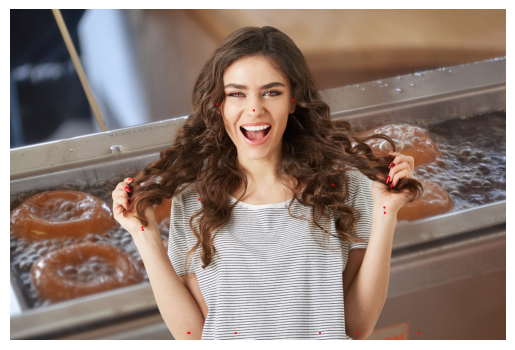

In [27]:
# 使用示例
image_path = files["FG"][220]  # 将此路径替换为你的图像文件路径
visualize_keypoints(image_path)


In [39]:
import numpy as np
import torch
from scipy.ndimage import gaussian_filter

def generate_heatmap(keypoints, output_shape, sigma=2):
    """
    根据关键点生成热力图。

    参数:
    - keypoints: numpy数组，形状为[num_keypoints, 3]，包含(x, y, visibility)。
    - output_shape: 热力图的形状，例如(128, 128)。
    - sigma: 高斯分布的标准差。
    
    返回:
    - 一个形状为[num_keypoints, height, width]的numpy数组，包含每个关键点的热力图。
    """
    num_keypoints = keypoints.shape[0]
    height, width = output_shape
    heatmaps = np.zeros((num_keypoints, height, width), dtype=np.float32)
    
    for i, (x, y, visibility) in enumerate(keypoints):
        if visibility > 0:  # 只处理可见的关键点
            x, y = int(x * width), int(y * height)  # 假设x, y是归一化坐标
            if 0 <= x < width and 0 <= y < height:
                heatmaps[i, y, x] = 1
                heatmaps[i] = gaussian_filter(heatmaps[i], sigma=sigma)
    
    return heatmaps

# 假设 `prediction` 是模型的输出
# 转换关键点坐标格式，假设关键点坐标已经归一化到[0, 1]区间
# 假设 `prediction` 是模型的输出
# 转换关键点坐标格式，假设关键点坐标已经归一化到[0, 1]区间
keypoints = prediction[0]['keypoints'][0].cpu().numpy()  # 获取第一个目标的关键点
keypoints[:, 0] = keypoints[:, 0] / 512 # 归一化x坐标
keypoints[:, 1] = keypoints[:, 1] / 512  # 归一化y坐标

# 生成热力图
heatmaps = generate_heatmap(keypoints, output_shape=(128, 128), sigma=2)

# 将热力图转换为PyTorch tensor，并添加一个批次维度
heatmaps_tensor = torch.tensor(heatmaps).unsqueeze(0)  # 

In [41]:
heatmaps_tensor.shape

torch.Size([1, 17, 128, 128])

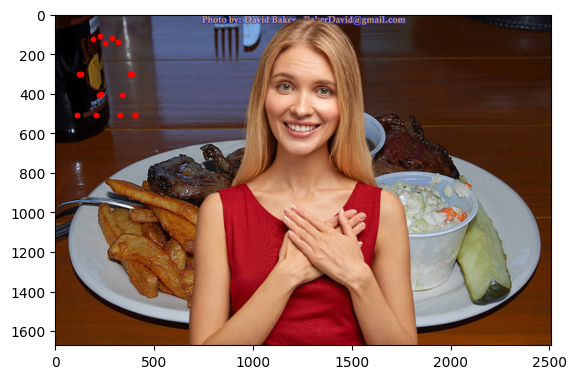

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def find_keypoint_positions(heatmaps_tensor, original_size=(512, 512), heatmap_size=(128, 128)):
    """
    从热力图中找到关键点的位置并缩放回原始图像尺寸。

    参数:
    - heatmaps_tensor: 形状为[1, num_keypoints, height, width]的热力图Tensor。
    - original_size: 原始图像的尺寸。
    - heatmap_size: 热力图的尺寸。
    
    返回:
    - 缩放后的关键点位置，形状为[num_keypoints, 2]的numpy数组。
    """
    scale_x, scale_y = original_size[0] / heatmap_size[0], original_size[1] / heatmap_size[1]
    keypoints = []
    for heatmap in heatmaps_tensor[0]:
        y, x = np.unravel_index(torch.argmax(heatmap), heatmap.shape)
        keypoints.append([x.item() * scale_x, y.item() * scale_y])
    return np.array(keypoints)

# 假设 heatmaps_tensor 是你已经有的热力图Tensor
# 假设 image 是原始图像的PIL实例或numpy数组
keypoints_scaled = find_keypoint_positions(heatmaps_tensor)

# 可视化
plt.imshow(image)  # 确保image是PIL图像或numpy数组
for x, y in keypoints_scaled:
    plt.scatter(x, y, color='red', s=10)  # 在关键点位置绘制红点
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def keypoints_to_heatmap(keypoints, image_shape, sigma=6):
    """
    将关键点转换为热力图。
    
    参数:
    - keypoints: 关键点坐标，形状为(num_keypoints, 3)，其中每行是(x, y, confidence)。
    - image_shape: 输出热力图的形状，为(height, width)。
    - sigma: 高斯滤波的标准差。
    
    返回:
    - 热力图，形状为(height, width)。
    """
    height, width = image_shape
    heatmap = np.zeros((height, width), dtype=np.float32)
    
    for x, y, confidence in keypoints:
        if confidence > 0:  # 只考虑置信度大于0的关键点
            x, y = int(x), int(y)
            if x >= 0 and x < width and y >= 0 and y < height:
                heatmap[y, x] = 1
    
    # 使用高斯滤波来模糊热点，模拟高斯分布
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    
    return heatmap

# 假设 keypoints 是模型对第一个实例检测到的关键点，形状为(num_keypoints, 3)
# 假设 image_shape 是你希望生成的热力图的尺寸，如(128, 128)
keypoints = prediction[0]['keypoints'][0].cpu().numpy()  # 转换为numpy数组，确保在CPU上
print(keypoints)
image_shape = (128, 128)  # 目标热力图尺寸

heatmap = keypoints_to_heatmap(keypoints, image_shape, sigma=20)

# 可视化热力图
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


In [27]:
gg = torch.load(heatmaps_dir)

In [31]:
[i.shape for i in gg.values()]

[(17, 128, 128), (17, 128, 128), (17, 128, 128)]

In [21]:
[[k,v.shape] for k,v in results.items()]

[['test01.jpg', (17, 128, 128)],
 ['test02.jpg', (17, 128, 128)],
 ['test03.jpg', (17, 128, 128)],
 ['test04.jpg', (17, 128, 128)]]

In [14]:
for paths in own["FG"]:
    print(paths)

test01.jpg
test02.jpg
test03.jpg
test04.jpg


In [ ]:

for file_name in tqdm(os.listdir(images_dir)):
    if file_name.endswith('.jpg'):  # 假设文件是JPG格式
        path = os.path.join(images_dir, file_name)
        image = Image.open(path).convert("RGB")
        original_shape = image.size  # 原始图像尺寸
        image_tensor = to_tensor(image).unsqueeze(0)

        # 模型预测
        output = model(image_tensor)
        if len(output[0]['keypoints']) > 0:  # 确保至少检测到一个目标
            keypoints = output[0]['keypoints'][0].numpy()  # 只处理第一个检测到的目标

            # 生成热力图
            heatmaps = generate_heatmap(keypoints, output_shape, original_shape)
        
            # 保存结果
            results[file_name] = heatmaps

# 保存所有热力图到单个文件
torch.save(results, heatmaps_dir)